In [1]:
import torch
import numpy as np
import scipy.stats

# Solutions

This notebook presents solutions for the problems in https://www.paradigm.xyz/open-problems/index.html in the zero-drift case.

That is, given known $\sigma$ and $\gamma$, and setting $\mu = \frac{\sigma^2}{2}$, we have:

## 3.1 Growth Rate of LP Wealth

$G = \mathop{\mathbb{E}}[\displaystyle{\lim_{T\to\inf}}\frac{1}{T}\log(W(T))] = \frac{-\sigma^2(1-\gamma)}{(1+\gamma)\log{\gamma}}\frac{1+e}{e-1}C$

Where $C\approx0.11$ is $G$ in the case where $\sigma=1, \gamma=e^{-1}$

 <a href='#3_1'>proof</a>

## 3.2  Optimal Fee

Accordingly, there is no optimal fee. $G$ increases asysmptotically as fees are reduced and smaller and smaller variations in price are captured:

$\displaystyle{\lim_{\gamma\to 1^-}} G = \frac{\sigma^2}{2}\frac{1+e}{e-1}C$

<a href='#3_2'>proof</a>


## 3.3  Excess Return

In the zero drift case, all $\sigma$ and $\gamma$ provide excess returns, as the expression in 3.1 cannot be negative.

# Methodology

One of the nice things about this setting is that we can simulate it almost perfectly.

First, trades in the same direction are path independent. Second, there is a buffer around the AMM price where changes in the market price won't trigger any trades. That means that if we pick a small enough time step, the probability of two path-dependent (i.e. opposite-sided) trades occuring is nearly zero.

I took advantage of this fact to build a simulation of the system in pytorch to help build my understanding and verify solutions.

All code is available at https://github.com/david-alexander-white/lp_wealth

## Time Step

Each of our time steps is going to have

std. dev = $\sigma * \sqrt{\Delta_t}$

in log space, so as long as we make sure

$2 * \lvert \log{\gamma} \rvert > 4 \sigma * \sqrt{\Delta_t} \iff \Delta_t < \frac{(\log{\gamma})^2}{4\sigma^2}$

then going from a trade to the upside to a trade to the downside will be a 4-sigma event.

However, we still see a difference in sim results below what should be a small enough time step

In [2]:
import lp_wealth
from sim_helpers import *
from notebook_helpers import *

1 0.0037908554077148438
101 0.29054832458496094
201 0.2637481689453125
301 0.3155655860900879
401 0.2569458484649658
501 0.3365974426269531
601 0.27591562271118164
701 0.3135659694671631
801 0.3090829849243164
901 0.3388392925262451


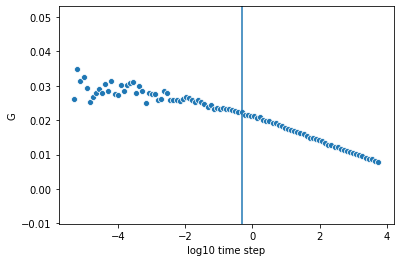

In [3]:
num_samples = 100000

sigma = torch.tensor(0.5)
mu = sigma **2 / 2
gamma = torch.tensor(0.5)

max_time_step = get_max_time_step(gamma, sigma)


log10_max_time_step = np.log10(max_time_step)
# Choose a ton of time steps ranging from 100x below our max to 100x above
time_step_size = torch.tensor(np.logspace(log10_max_time_step -2, log10_max_time_step +2, num_samples), dtype=sigma.dtype) 

sim = lp_wealth.Sim(mu, sigma, gamma, time_step_size, num_samples)

num_steps = 1000

sim_loop(sim, num_steps, bb_adjustment_type="none")

bins = np.logspace(log10_max_time_step -2, log10_max_time_step +2, 100) 

ax = bin_plot(torch.log(time_step_size).numpy(), sim.compute_wealth_growth_rate())

ax.set(xlabel='log10 time step', ylabel='G')
plt.axvline(log10_max_time_step)

## This problem can be fixed with a sampling adjustment

The problem is that we care about the most extreme values attained by the market price, which may occur in between our sampling steps. For example, if the price was 10 at the last step and 11 now, it may have been 12 in between.

Happily, the distribution of this maximum is known -- see https://www.researchgate.net/publication/236984395_On_the_maximum_of_the_generalized_Brownian_bridge eq. (2.7)

We can sample from this distribution to find the trades that went off between sample times.

1 0.03385496139526367
101 0.5417227745056152
201 0.4969625473022461
301 0.4725780487060547
401 0.32900118827819824
501 0.32982325553894043
601 0.32597780227661133
701 0.32959723472595215
801 0.31613850593566895
901 0.43176984786987305


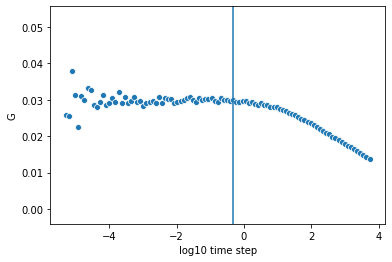

In [4]:
log10_max_time_step = np.log10(max_time_step)
# Choose a ton of time steps ranging from 100x below our max to 100x above
time_step_size = torch.tensor(np.logspace(log10_max_time_step -2, log10_max_time_step +2, num_samples), dtype=sigma.dtype) 

sim = lp_wealth.Sim(mu, sigma, gamma, time_step_size, num_samples)

sim_loop(sim, num_steps, bb_adjustment_type="sample")


ax = bin_plot(torch.log(time_step_size), sim.compute_wealth_growth_rate())
ax.set(xlabel='log10 time step', ylabel='G')
plt.axvline(log10_max_time_step)

<a id='3_1'></a>

# Proof of 3.1

Let wealth grown rate given $\mu, \sigma, \gamma = G(\mu,\sigma\gamma)$

### 1.) $\forall k \in \mathbb{R}^+, G(k^2\mu, k\sigma, \gamma) = k^2 G(\mu, \sigma, \gamma) $

The intuition here is that multiplying $\sigma$ by a constant $k$ has the same effect as speeding up the passage of time by $k^2$. If we adjust drift accordingly, that means growth rate will be $k^2$ higher.

1 0.0033926963806152344
161 0.6390364170074463
321 0.6425950527191162
481 0.6730146408081055
641 0.5053060054779053
801 0.5625684261322021
961 0.5051946640014648
1121 0.6641440391540527
1281 0.48938488960266113
1441 0.4935646057128906


[Text(0, 0.5, 'G'), Text(0.5, 0, '$\\k^2$')]

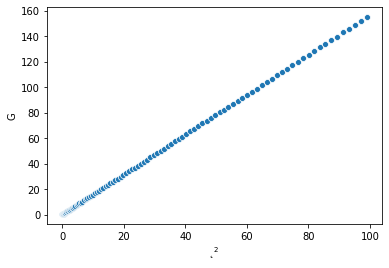

In [5]:
num_samples = 100000

k = torch.arange(0., num_samples, 1) / num_samples * 10 + 0.1
sigma = k
init_mu = 3
mu = init_mu * k**2
gamma = torch.tensor(0.6)

time_step = get_max_time_step(gamma, sigma)
num_steps = get_min_time_steps(sigma, gamma, time_step)

sim = lp_wealth.Sim(mu, sigma, gamma, time_step, num_samples)

sim_loop(sim, num_steps)

ax = bin_plot(k**2, sim.compute_wealth_growth_rate())

ax.set(xlabel='$\k^2$', ylabel='G')

### 2.) $\forall k \in \mathbb{R}^+, G(\frac{k^2\sigma^2}{2}, k\sigma, \gamma^k) = k\frac{1-\gamma^k}{1+\gamma^k}\frac{1 + \gamma}{1-\gamma} G(\frac{\sigma^2}{2}, \sigma, \gamma) $


The key intuition here is that, when viewed in log space, the AMM price $m_u$ is always inside a band of width $-2\log{\gamma}$ around the market price $m_p$, and trades occur at the boundary.

In the zero-drift case, by scaling both $\sigma$ and $\gamma$, we can scale both $m_p$ and the band, leading to a zoomed out view of the exact same behavior.

## Lemma 

Since

$\log{W(t)} = \log{R_\alpha m_p + R_\beta} = \log{R_\beta} + \log{(1 + \frac{R_\alpha m_p}{R_\beta})} = \log{R_\beta} + \log{(1 + \frac{m_p}{m_u})}$

Then we have

$G = \mathop{\mathbb{E}}[\displaystyle{\lim_{T\to\inf}}\frac{1}{T}\log(W(T))] = \mathop{\mathbb{E}}[\displaystyle{\lim_{T\to\inf}}\frac{1}{T}\log(R_\alpha m_p + R_\beta)] =  \mathop{\mathbb{E}}[\displaystyle{\lim_{T\to\inf}}\frac{1}{T}(\log{R_\beta})] $

since $\gamma \leq \frac{m_p}{m_u} \leq \frac{1}{\gamma}$ so $\log{(1 + \frac{m_p}{m_u})}$ has a finite bound and will get averaged out. 

Now, when $\mu = \frac{\sigma^2}{2}$, there's no drift in $\log{m_p}$, so by symmetry

$\mathop{\mathbb{E}}[\displaystyle{\lim_{T\to\inf}}\frac{1}{T}(\log{R_\beta})] = \mathop{\mathbb{E}}[\displaystyle{\lim_{T\to\inf}}\frac{1}{T}(\log{R_\alpha})]$

and we have $G = \mathop{\mathbb{E}}[\displaystyle{\lim_{T\to\inf}}\frac{1}{2T}(\log{R_\alpha} + \log{R_\beta})]$

## Main argument

Consider a single realization of our system of random variables -- i.e. one path in the geometric Brownian motion, and all the associated variables, which will change deterministically based on it.

We are going to compare what happens in this realization to what happens in the scaled realization.

We'll abuse notation a little bit and denote variables in the scaled realization with a prime mark ($'$). So $m_p' = k m_p$ (since we're in the 0 drift setting), $m_u'=km_u$, $\gamma' = \gamma^k$, etc.

WLOG, consider what happens when $\gamma m_p > m_u$ -- i.e. the market price has drifted above the AMM price by more than our fee.

An arb will go off, after which we will have $R_\alpha(t+\delta t) = R_\alpha(t)C_l^{-\frac{\gamma}{\gamma+1}}$

so

$\log{R_\alpha(t+\delta t)} = \log{R_\alpha(t)} -\frac{\gamma}{\gamma+1}\log{C_l}$

similarly,

$\log{R_\beta(t+\delta t)} = \log{R_\beta(t)} +\frac{1}{\gamma+1}\log{C_l}$

so

$\Delta_l = \log{R_\alpha(t+\delta t)} + \log{R_\beta(t+\delta t)} - (\log{R_\alpha(t)} + \log{R_\beta(t)})=  \frac{1-\gamma}{\gamma+1}\log{C_l}$


Now, $C_l = \gamma\frac{m_p}{m_u} \iff \log{C_l} = \log{\gamma} + \log{m_p} - \log{m_u}$.

Each term in the RHS gets scaled by $k$ in the scaled realization, so we have $\log{C_l'} = k\log{C_l}$.

So then we obtain 

$\Delta'_l = \log{R'_\alpha(t+\delta t)} + \log{R'_\beta(t+\delta t)} - (\log{R'_\alpha(t)} + \log{R'_\beta(t)})=  \frac{1-\gamma'}{\gamma'+1}\log{C'_l} = \frac{1-\gamma'}{\gamma'+1}\log{C'_l} = k\frac{1-\gamma^k}{1+\gamma^k}\log{C_l}$

And, dividing through, $\frac{\Delta'_l}{\Delta_l} = k\frac{1-\gamma^k}{1+\gamma^k}\frac{1+\gamma}{1-\gamma}$

Integrating, we obtain 

$\log{R'_\alpha} + \log{R'_\beta} = k\frac{1-\gamma^k}{1+\gamma^k}\frac{1+\gamma}{1-\gamma}( \log{R_\alpha} + \log{R_\beta})$


Since this is true for all paths, when we combine this with the lemma, we see that in fact $G(\frac{k^2\sigma^2}{2}, k\sigma, \gamma^k) = k\frac{1-\gamma^k}{1+\gamma^k}\frac{1 + \gamma}{1-\gamma} G(\frac{\sigma^2}{2}, \sigma, \gamma)$



1 0.013389825820922852
161 0.9214074611663818
321 0.7870907783508301
481 0.8261415958404541
641 0.641442060470581
801 0.574223518371582
961 0.6920349597930908
1121 0.5860159397125244
1281 0.5898642539978027
1441 0.594059944152832


[Text(0, 0.5, 'G'), Text(0.5, 0, '$pred$')]

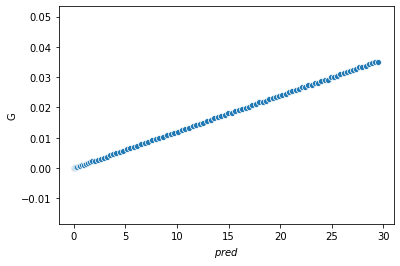

In [6]:
num_samples = 100000

k = torch.arange(0., num_samples, 1) / num_samples * 10 + 0.01
init_sigma = 0.1
sigma = init_sigma * k
mu = sigma**2 / 2
init_gamma = torch.tensor(0.5)
gamma = init_gamma ** k

time_step = get_max_time_step(gamma, sigma)
num_steps = get_min_time_steps(sigma, gamma, time_step)

sim = lp_wealth.Sim(mu, sigma, gamma, time_step, num_samples)

sim_loop(sim, num_steps)

pred = (k * (1+init_gamma)/(1-init_gamma)*(1-gamma)/(1+gamma)).numpy()

ax = bin_plot(pred, sim.compute_wealth_growth_rate())
ax.set(xlabel='$pred$', ylabel='G')

### 3.) $\forall k \in \mathbb{R}^+, G(\frac{\sigma^2}{2}, \sigma, \gamma^k) = \frac{1}{k}\frac{1+\gamma}{1-\gamma}\frac{1-\gamma^k}{1+\gamma^k} G(\frac{\sigma^2}{2}, \sigma, \gamma)$

Obtained simply by combining (1) and (2).


1 0.00630640983581543
161 0.5325839519500732
321 0.513129472732544
481 0.5410428047180176
641 0.5241124629974365
801 0.546250581741333
961 0.527306079864502
1121 0.5293521881103516
1281 0.5399024486541748
1441 0.5529346466064453


[Text(17.200000000000003, 0.5, 'G'), Text(0.5, 21.200000000000003, '$pred$')]

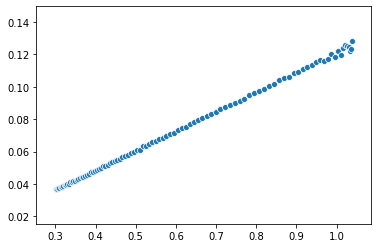

In [7]:
num_samples = 100000

k = torch.arange(0., num_samples, 1) / num_samples * 10  + 0.01
sigma = torch.tensor(1.)
mu = sigma**2 / 2
init_gamma = torch.tensor(0.5)
gamma = init_gamma ** k

time_step = get_max_time_step(gamma, sigma)
num_steps = get_min_time_steps(sigma, gamma, time_step)

sim = lp_wealth.Sim(mu, sigma, gamma, time_step, num_samples)

sim_loop(sim, num_steps)

pred = (1/k * (1+init_gamma)/(1-init_gamma)*(1-init_gamma**(k))/(1+init_gamma**k)).numpy()

bin_plot(pred, sim.compute_wealth_growth_rate())

ax.set(xlabel='$pred$', ylabel='G')

<a id='3_2'></a>

# Optimal Fee

There is no optimal $\gamma$ in the no-drift case. LPs make more and more money as $\gamma$ is brought closer to 1, although profits approach an asymptote:


$\displaystyle{\lim_{k\to 0^+}} G(\frac{\sigma^2}{2}, \sigma, \gamma^k)= \displaystyle{\lim_{k\to 0}} \frac{1}{k}\frac{1+\gamma}{1-\gamma}\frac{1-\gamma^k}{1+\gamma^k} G(\frac{\sigma^2}{2}, \sigma, \gamma) = -\frac{(1+\gamma)\log{\gamma}}{2(1-\gamma)} G(\frac{\sigma^2}{2}, \sigma, \gamma)$

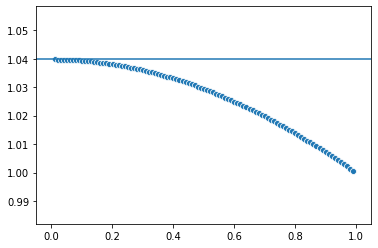

In [8]:
k = np.arange(1, 100)/100 + 0.001
gamma = .5
ans = 1 / k * (1+gamma) / (1-gamma)*(1-gamma**k)/(1+gamma**k)
sbn.scatterplot(k, ans)
plt.axhline(-np.log(gamma)/2*(1+gamma)/(1-gamma))